# Uploading files from kaggle

In [1]:
! pip install -q kaggle
from google.colab import files

In [2]:
# choose the kaggle.json file that you downloaded
files.upload()
! mkdir ~/.kaggle


Saving kaggle.json to kaggle.json


In [3]:
# make a directory named kaggle and copy the kaggle.json file there
!cp kaggle.json ~/.kaggle/



In [4]:
# change the permissions of the file
! chmod 600 ~/.kaggle/kaggle.json


In [5]:
! kaggle datasets download -d subhankarpanda56/news-bias

 99% 109M/110M [00:08<00:00, 13.9MB/s]
100% 110M/110M [00:08<00:00, 13.7MB/s]


In [6]:
! unzip news-bias.zip

Archive:  news-bias.zip
  inflating: new_bias.csv            


# Installing and importing libraries

In [7]:
!pip install transformers


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 60.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.1/200.1 kB 24.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 17.6 MB/s eta 0:00:00


In [8]:
! pip install torch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [9]:
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader

In [10]:
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# DATA PREPROCESSING

In [12]:
df = pd.read_csv("/content/new_bias.csv")
df.head(5)

,topic,source,bias,url,title,date,authors,content,content_original,source_url,bias_text,ID
0,terrorism,New York Times - News,0,http://www.nytimes.com/2016/09/20/nyregion/ahm...,"Bomb Suspect Changed After Trip Abroad, Friend...",2016-09-20,N. R. Kleinfield,"Besides his most recent trip to Quetta , Mr. R...","Besides his most recent trip to Quetta, Mr. Ra...",www.nytimes.com,left,004Gt3gcsotuiYmz
1,supreme_court,Vox,0,https://www.vox.com/policy-and-politics/2018/9...,Why Susan Collins claims she’s being bribed ov...,2018-09-12,"Emily Stewart, Terry Nguyen, Rebecca Jennings,...",Is Maine Republican Sen. Susan Collins being b...,Is Maine Republican Sen. Susan Collins being b...,www.vox.com,left,00eP4XD3VdMmHITE
2,education,Ezra Klein,0,http://www.npr.org/blogs/thetwo-way/2014/05/06...,Poll: Prestigious Colleges Won't Make You Happ...,2014-05-06,Anya Kamenetz,Poll : Prestigious Colleges Wo n't Make You Ha...,Poll: Prestigious Colleges Won't Make You Happ...,www.npr.org,left,00FTGIZEd6B8zQ4U
3,us_house,Breitbart News,2,http://www.breitbart.com/big-government/2017/0...,Paul Ryan Reportedly Says No Chance for Border...,2017-09-12,Ian Mason,"House Speaker Paul Ryan , at a private dinner ...","House Speaker Paul Ryan, at a private dinner e...",www.breitbart.com,right,00HGGqBRf1kzPRlg
4,white_house,Guest Writer - Left,0,https://www.cnn.com/2019/07/11/politics/donald...,OPINION: Trump seeking change of legal fortune...,2019-07-11,Analysis Stephen Collinson,( CNN ) President Donald Trump has reason to h...,(CNN) President Donald Trump has reason to hop...,www.cnn.com,left,00IzI5ynahBVtC9l


In [13]:
df.shape


(37554, 12)

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37554 entries, 0 to 37553
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   topic             37554 non-null  object
 1   source            37554 non-null  object
 2   bias              37554 non-null  int64 
 3   url               37554 non-null  object
 4   title             37554 non-null  object
 5   date              33147 non-null  object
 6   authors           27886 non-null  object
 7   content           37554 non-null  object
 8   content_original  37554 non-null  object
 9   source_url        37554 non-null  object
 10  bias_text         37554 non-null  object
 11  ID                37554 non-null  object
dtypes: int64(1), object(11)
memory usage: 3.4+ MB


<Axes: >

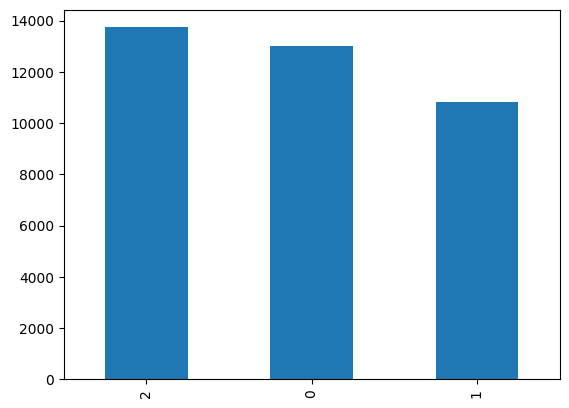

In [15]:
df['bias'].value_counts().plot(kind='bar')

In [16]:
class_names = ['left', 'neutral', 'right']

In [17]:
PRE_TRAINED_MODEL_NAME = 'bert-base-uncased'

In [18]:
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

In [19]:
MAX_LEN = 256

### Sliding window approach -  splitting the long articles into smaller sections and feed them to the model separately, as BERT has limitation of max sequence length of 512 tokens.

In [20]:
class GPReviewDataset(Dataset):
  def __init__(self, reviews, targets, tokenizer, max_len, stride):
    self.reviews = reviews
    self.targets = targets
    self.tokenizer = tokenizer
    self.max_len = max_len
    self.stride = stride
    
  def __len__(self):
    return len(self.reviews)
  
  def __getitem__(self, item):
    review = str(self.reviews[item])
    target = self.targets[item]
    encoding = self.tokenizer.encode_plus(
      review,
      add_special_tokens=True,
      max_length=self.max_len,
      return_token_type_ids=False,
      padding="max_length",
      truncation= True,
      return_attention_mask=True,
      return_tensors='pt',
    )
    input_ids = encoding['input_ids'].flatten()
    attention_mask = encoding['attention_mask'].flatten()

    if len(input_ids) <= self.max_len:
      return {
        'review_text': review,
        'input_ids': input_ids,
        'attention_mask': attention_mask,
        'targets': torch.tensor(target, dtype=torch.long)
      }

    # Split the input into overlapping sections
    inputs = []
    masks = []
    for i in range(0, len(input_ids), self.stride):
      if i + self.max_len > len(input_ids):
        break
      inputs.append(input_ids[i:i+self.max_len])
      masks.append(attention_mask[i:i+self.max_len])
    targets = [target] * len(inputs)

    return {
      'review_text': review,
      'input_ids': torch.tensor(inputs, dtype=torch.long),
      'attention_mask': torch.tensor(masks, dtype=torch.long),
      'targets': torch.tensor(targets, dtype=torch.long)
    }


In [21]:
df1 = df.sample(n=20000)

In [22]:
df_train, df_test = train_test_split(
  df1,
  test_size=0.3,
  random_state=RANDOM_SEED
)
df_val, df_test = train_test_split(
  df_test,
  test_size=0.5,
  random_state=RANDOM_SEED
)

In [23]:
df_train.shape, df_val.shape, df_test.shape

((14000, 12), (3000, 12), (3000, 12))

In [24]:
def create_data_loader(df, tokenizer, max_len, stride, batch_size):
  ds = GPReviewDataset(
    reviews=df.content.to_numpy(),
    targets=df.bias.to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len,
    stride=stride
  )
  return DataLoader(
    ds,
    batch_size=batch_size,
    num_workers=4
  )


In [25]:
BATCH_SIZE = 16
MAX_LEN = 256
STRIDE = 128

train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, STRIDE, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, STRIDE, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, STRIDE, BATCH_SIZE)


/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [26]:
data = next(iter(train_data_loader))
data.keys()

dict_keys(['review_text', 'input_ids', 'attention_mask', 'targets'])

In [27]:
print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['targets'].shape)

torch.Size([16, 256])
torch.Size([16, 256])
torch.Size([16])


# LOADING MODELS

In [28]:
bert_model = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [29]:
sample_txt = "This is a sample text"

In [30]:
encoding = tokenizer.encode_plus(
  sample_txt,
  max_length=256,
  add_special_tokens=True, # Add '[CLS]' and '[SEP]'
  return_token_type_ids=False,
  padding=True,
  truncation=True,
  return_attention_mask=True,
  return_tensors='pt',  # Return PyTorch tensors
)
encoding.keys()

dict_keys(['input_ids', 'attention_mask'])

In [31]:
last_hidden_state, pooled_output = bert_model(
  input_ids=encoding['input_ids'],
  attention_mask=encoding['attention_mask']
)

In [32]:
bert_model.config.hidden_size

768

In [33]:
class SentimentClassifier(nn.Module):
  def __init__(self, n_classes):
    super(SentimentClassifier, self).__init__()
    self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
    self.drop = nn.Dropout(p=0.4)
    self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
  def forward(self, input_ids, attention_mask):
    _, pooled_output = self.bert(
      input_ids=input_ids,
      attention_mask=attention_mask,
      return_dict=False
      
    )
    output = self.drop(pooled_output)
    return self.out(output)

In [34]:
model = SentimentClassifier(len(class_names))
model = model.to(device)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [35]:
input_ids = data['input_ids'].to(device)
attention_mask = data['attention_mask'].to(device)
print(input_ids.shape) # batch size x seq length
print(attention_mask.shape) # batch size x seq length

torch.Size([16, 256])
torch.Size([16, 256])


In [36]:
import torch.nn.functional as F
F.softmax(model(input_ids, attention_mask), dim=1)

tensor([[0.3778, 0.2332, 0.3890],
        [0.4116, 0.3675, 0.2210],
        [0.2851, 0.3623, 0.3526],
        [0.4550, 0.2821, 0.2629],
        [0.3590, 0.2960, 0.3451],
        [0.4825, 0.2905, 0.2270],
        [0.2941, 0.3265, 0.3794],
        [0.3342, 0.2719, 0.3939],
        [0.3862, 0.2916, 0.3222],
        [0.3813, 0.3740, 0.2447],
        [0.3296, 0.3186, 0.3518],
        [0.5533, 0.2244, 0.2223],
        [0.3270, 0.4010, 0.2720],
        [0.2743, 0.2948, 0.4309],
        [0.3369, 0.4156, 0.2474],
        [0.4329, 0.1895, 0.3777]], device='cuda:0', grad_fn=<SoftmaxBackward0>)

### Making a custom loss function that assigns different weights to class pairs based on their importance and calculates cross-entropy loss with weighted targets.

In [37]:
EPOCHS = 4
optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False, weight_decay=0.01)
total_steps = len(train_data_loader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

import torch.nn.functional as F

class CustomLoss(nn.Module):
  def __init__(self, num_classes):
    super(CustomLoss, self).__init__()
    self.num_classes = num_classes
    self.weights = torch.ones((num_classes, num_classes))
    # Assign different weights to class pairs
    self.weights[0][1] = 2.0  # left vs centre
    self.weights[0][2] = 3.0  # left vs right
    self.weights[1][0] = 2.0  # centre vs left
    self.weights[1][2] = 2.5  # centre vs right
    self.weights[2][0] = 3.0  # right vs left
    self.weights[2][1] = 2.5  # right vs centre

  def forward(self, input, target):
    class_weights = torch.sum(self.weights, dim=1)
    return F.cross_entropy(input, target, weight=class_weights.to(device))


# Replace the previous loss function with the custom loss function
loss_fn = CustomLoss(num_classes=len(class_names)).to(device)


/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [38]:
def train_epoch(
  model,
  data_loader,
  loss_fn,
  optimizer,
  device,
  scheduler,
  n_examples
):
  model = model.train()
  losses = []
  correct_predictions = 0
  for d in data_loader:
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    targets = d["targets"].to(device)
    outputs = model(
      input_ids=input_ids,
      attention_mask=attention_mask
    )
    _, preds = torch.max(outputs, dim=1)
    loss = loss_fn(outputs, targets)
    correct_predictions += torch.sum(preds == targets)
    losses.append(loss.item())
    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()
  return correct_predictions.double() / n_examples, np.mean(losses)

In [39]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()
  losses = []
  correct_predictions = 0
  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)
      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)
      loss = loss_fn(outputs, targets)
      correct_predictions += torch.sum(preds == targets)
      losses.append(loss.item())
  return correct_predictions.double() / n_examples, np.mean(losses)

# TRAINING

In [40]:
%%time
history = defaultdict(list)
best_accuracy = 0
for epoch in range(EPOCHS):
  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)
  train_acc, train_loss = train_epoch(
    model,
    train_data_loader,
    loss_fn,
    optimizer,
    device,
    scheduler,
    len(df_train)
  )
  print(f'Train loss {train_loss} accuracy {train_acc}')
  val_acc, val_loss = eval_model(
    model,
    val_data_loader,
    loss_fn,
    device,
    len(df_val)
  )
  print(f'Val   loss {val_loss} accuracy {val_acc}')
  print()
  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)
  if val_acc > best_accuracy:
    torch.save(model.state_dict(), 'best_model_state.bin')
    best_accuracy = val_acc

Epoch 1/4
----------
Train loss 0.9653975095067705 accuracy 0.4830714285714286
Val   loss 0.705084038383149 accuracy 0.6933333333333334

Epoch 2/4
----------
Train loss 0.6294909041949681 accuracy 0.7334285714285714
Val   loss 0.6289339650501596 accuracy 0.7473333333333333

Epoch 3/4
----------
Train loss 0.4352376897696938 accuracy 0.8342142857142858
Val   loss 0.7223810761612146 accuracy 0.7536666666666666

Epoch 4/4
----------
Train loss 0.3248391018563083 accuracy 0.8801428571428572
Val   loss 0.7593585539886609 accuracy 0.7576666666666666

CPU times: user 31min 58s, sys: 17.9 s, total: 32min 16s
Wall time: 44min 47s


In [41]:
test_acc, _ = eval_model(
  model,
  test_data_loader,
  loss_fn,
  device,
  len(df_test)
)
test_acc.item()

0.7486666666666666

In [42]:
def get_predictions(model, data_loader):
  model = model.eval()
  review_texts = []
  predictions = []
  prediction_probs = []
  real_values = []
  with torch.no_grad():
    for d in data_loader:
      texts = d["review_text"]
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)
      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)
      review_texts.extend(texts)
      predictions.extend(preds)
      prediction_probs.extend(outputs)
      real_values.extend(targets)
  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()
  return review_texts, predictions, prediction_probs, real_values

In [43]:
y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(
  model,
  test_data_loader
)

In [44]:
print(classification_report(y_test, y_pred, target_names=class_names))

              precision    recall  f1-score   support

        left       0.75      0.77      0.76      1041
     neutral       0.77      0.71      0.74       833
       right       0.74      0.75      0.75      1126

    accuracy                           0.75      3000
   macro avg       0.75      0.75      0.75      3000
weighted avg       0.75      0.75      0.75      3000



In [45]:
from sklearn.metrics import f1_score

review_texts, predictions, _, real_values = get_predictions(model, test_data_loader)
f1_macro = f1_score(real_values, predictions, average='macro')
print('Macro F1 score:', f1_macro)


/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Macro F1 score: 0.7479444207853122


In [47]:
def class_imbalance_metric(targets, predictions):
    """
    Calculates the class imbalance metric.

    Args:
        targets (numpy.ndarray): True class labels.
        predictions (numpy.ndarray): Predicted class labels.

    Returns:
        float: The class imbalance metric.
    """
    counts = np.bincount(targets)
    weights = counts.sum() / (len(counts) * counts)
    return (weights * (1 - (counts / len(targets)))).sum()

In [52]:
from sklearn.metrics import confusion_matrix

def class_imbalance_metric(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    total = cm.sum()
    correct = sum([cm[i][i] for i in range(len(cm))])
    return correct / total




In [53]:
# get model predictions
review_texts, preds, pred_probs, targets = get_predictions(model, test_data_loader)

# convert predictions and targets to numpy arrays
preds = preds.numpy()
targets = targets.numpy()

# calculate class imbalance metric
imbalance_metric = class_imbalance_metric(targets, preds)
print("Class Imbalance Metric: ", imbalance_metric)




Class Imbalance Metric:  0.7486666666666667


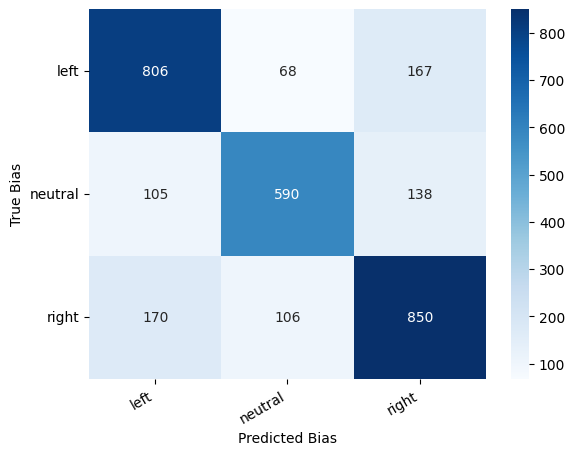

In [54]:
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True Bias')
  plt.xlabel('Predicted Bias');
cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)

## Saving the model

In [55]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [56]:
import pickle

In [57]:
pickle.dump(model,open("/content/drive/MyDrive/saved_models/model_BERT_1", 'wb'))

In [58]:
pickle.dump(model,open("/content/drive/MyDrive/saved_models/model_1_BERT_1", 'wb'))

In [59]:
review_text = " The U.S. Supreme Court on Friday temporarily blocked a federal court’s ruling that suspended the FDA’s approval of the abortion pill.Justice Alito issued the administrative stay of U.S. District Judge Kacsmaryk’s ruling dealing with the circulation of mifepristone, one of two drugs commonly involved in a chemical abortion regime. Mifepristone, a progesterone blocker, kills the unborn baby by depriving it of nutrients, and misoprostol causes uterine contractions to empty the uterus. Over half of all abortions in the U.S. are done using the two-drug combination.The stay applies until 11:59 p.m. ET on Wednesday. Any response to the application must be filed on or before Tuesday, April 18, 2023 by 12 p.m., the order states.After Kacsmaryk’s order, the Department of Justice appealed the decision in the case, which has now been escalated to the Supreme Court. His injunction overturned the FDA’s approval of mifepristone in 2000, stopping short of completely withdrawing or suspending the agency’s approval of the druver the objections of pro-life groups. On the heels of that ruling came a contradictory one from a Washington State federal judge.The Court does not second-guess FDA’s decision-making lightly,” Kacsmaryk wrote in the 67-page opinion. “But here, FDA acquiesced on its legitimate safety concerns — in violation of its statutory duty — based on plainly unsound reasoning and studies that did not support its conclusions.The case stems from a lawsuit filed in November by Alliance Defending Freedom on behalf of the Alliance for Hippocratic Medicine, an organization of pro-life medical groups, as well as four pro-life doctors. The lawsuit argued that the FDA failed to conduct a thorough safety assessment of the drug before it granted approval nearly a quarter century ago. The FDA eliminated existing safeguards and made the drug more accessible when it should have increased oversight of the drugs, the plaintiffs allege.ADF also say that the FDA improperly invoked a certain regulation, called Subpart H, to justify its approval of mifepristone. Subpart H allows for expedited approval of potentially dangerous drugs that can be used to treat “serious or life-threatening illnesses” or that provide a “meaningful therapeutic advantage over existing treatment.” ADF rebutted that pregnancy is not an illness to be remedied but a “normal physiological state that many females experience one or more times during their childbearing years.” The abortion pill poses a greater health risk to the mother than surgical abortion, the ADF attorneys also contend."


In [60]:
encoded_review = tokenizer.encode_plus(
  review_text,
  max_length=MAX_LEN,
  add_special_tokens=True,
  return_token_type_ids=False,
  padding="max_length",
  truncation=True,
  return_attention_mask=True,
  return_tensors='pt',
)

In [61]:
input_ids = encoded_review['input_ids'].to(device)
attention_mask = encoded_review['attention_mask'].to(device)
output = model(input_ids, attention_mask)
_, prediction = torch.max(output, dim=1)
print(f'News Article: {review_text}')
print(f'Bias  : {class_names[prediction]}')

News Article:  The U.S. Supreme Court on Friday temporarily blocked a federal court’s ruling that suspended the FDA’s approval of the abortion pill.Justice Alito issued the administrative stay of U.S. District Judge Kacsmaryk’s ruling dealing with the circulation of mifepristone, one of two drugs commonly involved in a chemical abortion regime. Mifepristone, a progesterone blocker, kills the unborn baby by depriving it of nutrients, and misoprostol causes uterine contractions to empty the uterus. Over half of all abortions in the U.S. are done using the two-drug combination.The stay applies until 11:59 p.m. ET on Wednesday. Any response to the application must be filed on or before Tuesday, April 18, 2023 by 12 p.m., the order states.After Kacsmaryk’s order, the Department of Justice appealed the decision in the case, which has now been escalated to the Supreme Court. His injunction overturned the FDA’s approval of mifepristone in 2000, stopping short of completely withdrawing or suspe

In [62]:
review_text1 = "Supreme Court Justice Samuel Alito on Friday extended a hold on a lower court ruling that would have imposed restrictions on access to an abortion drug, a temporary move meant to give the justices more time to consider the issue.Alito said the order is stayed until 11:59 p.m. ET on Wednesday. He also asked plaintiffs to respond on or before noon ET Tuesday.The case is the most important abortion-related dispute to reach the high court since the justices overturned Roe v. Wade last term. It centers on the scope of the US Food and Drug Administration’s authority to regulate a drug that is used in the majority of abortions today in states that still allow the procedure.Alito issued a so-called administrative stay on the ruling while the high court considers an emergency appeal filed by the Biden administration and a manufacturer of the drug, mifepristone. The move does not reflect the final disposition of the case.Parts of the ruling by US District Court Judge Matthew Kacsmaryk that restricted access to the drugwere set to go into effect Saturday at 1 a.m. ET, but the latest development puts off that deadline in the fast-moving dispute.Alito issued the order because he has jurisdiction over the federal appeals court involved in the case.Hours after the temporary freeze was ordered, a significant number of “friend of the court briefs” flowed into the high court.These included briefs from Democratic-led states, 253 members of Congress, pharmaceutical companies, food and drug scholars, former FDA officials, and over 200 reproductive health organizations.“The perils of this unwarranted judicial intervention into science-based determinations can hardly be overstated,” the members of Congress wrote.Solicitor General Elizabeth Prelogar said in the filing from Biden’s Justice Department earlier Friday that it “concerns unprecedented lower court orders countermanding FDA’s scientific judgment and unleashing regulatory chaos by suspending the existing FDA-approved conditions of use for mifepristone.”She said that if the ruling were allowed to stand it would “inflict grave harm on women, the medical system, the agency, and the public.”President Joe Biden echoed those remarks early Saturday morning upon returning from his trip to Ireland.“I think it’s outrageous what the court has done, relative to concluding that they’re going to overrule the FDA on whether something is safe or not,” he said. “I think it’s out of their domain.”20230413-telehealth-abortion-cardTelehealth medication abortions surged since Dobbs decision. They could become harder to access if the latest court decision standsDanco, a manufacturer of the drug, also asked the justices to step in on an emergency basis before Friday, with an attorney for the company saying in its filing that leaving the lower court opinion in play will “irreparably harm Danco, which will be unable to both conduct its business nationwide and comply with its legal obligations under the FDCA nationwide.”“The lack of emergency relief from this Court will also harm women, the healthcare system, the pharmaceutical industry, States’ sovereignty interests, and the separation-of-powers,” the attonrey, Jessica L. Ellsworth, told the justices.The controversy began when Kacsmaryk issued a broad ruling last week that blocked the FDA’s 2000 approval of the drug, as well as changes the FDA made in subsequent years to make the drug more accessible.Late Wednesday, the 5th US Circuit Court of Appeals froze part of the ruling. The court said the drug, that was approved in 2000, could stay on the market, but agreed with Kacsmaryk that access could be limited.The appeals court ordered a return to the stricter, pre-2016 FDA regime around the drug, which prevents mailing the pill to patients who obtained it through telehealth, or virtual visits with their providers rather than traveling to a clinic or hospital to obtain the drug in person."


In [63]:
encoded_review = tokenizer.encode_plus(
  review_text1,
  max_length=MAX_LEN,
  add_special_tokens=True,
  return_token_type_ids=False,
  padding="max_length",
  truncation=True,
  return_attention_mask=True,
  return_tensors='pt',
)

In [64]:
input_ids = encoded_review['input_ids'].to(device)
attention_mask = encoded_review['attention_mask'].to(device)
output = model(input_ids, attention_mask)
_, prediction = torch.max(output, dim=1)
print(f'News Article: {review_text}')
print(f'Bias  : {class_names[prediction]}')

News Article:  The U.S. Supreme Court on Friday temporarily blocked a federal court’s ruling that suspended the FDA’s approval of the abortion pill.Justice Alito issued the administrative stay of U.S. District Judge Kacsmaryk’s ruling dealing with the circulation of mifepristone, one of two drugs commonly involved in a chemical abortion regime. Mifepristone, a progesterone blocker, kills the unborn baby by depriving it of nutrients, and misoprostol causes uterine contractions to empty the uterus. Over half of all abortions in the U.S. are done using the two-drug combination.The stay applies until 11:59 p.m. ET on Wednesday. Any response to the application must be filed on or before Tuesday, April 18, 2023 by 12 p.m., the order states.After Kacsmaryk’s order, the Department of Justice appealed the decision in the case, which has now been escalated to the Supreme Court. His injunction overturned the FDA’s approval of mifepristone in 2000, stopping short of completely withdrawing or suspe

###  IT CORRECTLY PREDICTED THIS NEWS ARTICLE FROM ALL SIDES,                   
RIGHT BIASED NEW ARTICLE https://www.allsides.com/news/2023-04-14-1518/abortion-us-supreme-court-stays-ruling-suspended-abortion-pill-approval

LEFT BIASED NEWS ARTICLE: https://www.allsides.com/news/2023-04-14-1316/supreme-court-justice-samuel-alito-temporarily-extends-access-abortion-drug

In [ ]:
tokenizer.save_pretrained('/content/drive/MyDrive/saved_models')
